In [4]:
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [9]:
# import data from csv
data=pd.read_csv("flight_data.csv",na_filter=True,na_values="NA",dtype={'dep_time':'float','sched_dep_time':'float',
                                                                        'dep_delay':'float','arr_time':'float',
                                                                        'sched_arr_time':'float','arr_delay':'float',
                                                                        'air_time':'float','distance':'float'} )
data=data.dropna() #drop incomplete rows
# drop unnecessary columns. 
# year is only 2013 so we can drop it too.
data=data.drop(columns=["year","day","flight","tailnum","hour","minute","time_hour"]) 
print(data)

        month  dep_time  sched_dep_time  dep_delay  arr_time  sched_arr_time  \
0           1     517.0           515.0        2.0     830.0           819.0   
1           1     533.0           529.0        4.0     850.0           830.0   
2           1     542.0           540.0        2.0     923.0           850.0   
3           1     544.0           545.0       -1.0    1004.0          1022.0   
4           1     554.0           600.0       -6.0     812.0           837.0   
...       ...       ...             ...        ...       ...             ...   
336765      9    2240.0          2245.0       -5.0    2334.0          2351.0   
336766      9    2240.0          2250.0      -10.0    2347.0             7.0   
336767      9    2241.0          2246.0       -5.0    2345.0             1.0   
336768      9    2307.0          2255.0       12.0    2359.0          2358.0   
336769      9    2349.0          2359.0      -10.0     325.0           350.0   

        arr_delay carrier origin dest  

# Data Cleaning for Linear Regression


In [10]:
# Data clean up for Linear regression

# we will only be using month, dep_time, dep_delay, carrier, origin, distance to predict arr_delay
linearReg=data.drop(['sched_dep_time','arr_time','sched_arr_time','dest','air_time'], axis='columns')

# In NYC, seasons are as follow:
# Winter: December to February.
# Spring: March to May.
# Summer: June to August.
# Autumn: September to November.
# Instead of having months, we will change it to quarters.
# 1 for Winter
# 2 for Spring
# 3 for Summer
# 4 for Autumn

monthConditions = [
    (linearReg['month'] == 12)|(linearReg['month']==1)|(linearReg['month']==2),
    (linearReg['month'] == 3)|(linearReg['month']==4)|(linearReg['month']==5),
    (linearReg['month'] == 6)|(linearReg['month']==7)|(linearReg['month']==8),
    (linearReg['month'] == 9)|(linearReg['month']==10)|(linearReg['month']==11)
]

monthValues = [1,2,3,4]

linearReg['quarters'] = np.select(monthConditions, monthValues)
linearReg.drop(["month"],axis="columns",inplace=True);

# We will categorise non-numeric columns origin and carrier

o=linearReg['origin'].astype('category')
linearReg['origin']=o.cat.codes

c=linearReg['carrier'].astype('category')
linearReg['carrier']=c.cat.codes

# We will group the depature and arrival time into 4 groups as well.
# 1 for 0000-0559
# 2 for 0600-1159
# 3 for 1200-1759
# 4 for 1800-2359

timeConditions = [
    ((linearReg['dep_time'] >= 0)&(linearReg['dep_time']<=559))|(linearReg['dep_time'] == 2400),
    (linearReg['dep_time'] >= 600)&(linearReg['dep_time']<=1159),
    (linearReg['dep_time'] >= 1200)&(linearReg['dep_time']<=1759),
    (linearReg['dep_time'] >= 1800)&(linearReg['dep_time']<=2359)
]

timeValues = [1,2,3,4]

linearReg['dep_time'] = np.select(timeConditions, timeValues)
linearReg

,dep_time,dep_delay,arr_delay,carrier,origin,distance,quarters
0,1,2.0,11.0,11,0,1400.0,1
1,1,4.0,20.0,11,2,1416.0,1
2,1,2.0,33.0,1,1,1089.0,1
3,1,-1.0,-18.0,3,1,1576.0,1
4,1,-6.0,-25.0,4,2,762.0,1
...,...,...,...,...,...,...,...
336765,4,-5.0,-17.0,3,1,209.0,4
336766,4,-10.0,-20.0,3,1,301.0,4
336767,4,-5.0,-16.0,3,1,264.0,4
336768,4,12.0,1.0,3,1,187.0,4


In [11]:
linearReg.describe()

,dep_time,dep_delay,arr_delay,carrier,origin,distance,quarters
count,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000,327346.000000
mean,2.807445,12.555156,6.895377,6.150104,0.951162,1048.371314,2.526333
std,0.821983,40.065688,44.633292,4.138973,0.815104,735.908523,1.106615
min,1.000000,-43.000000,-86.000000,0.000000,0.000000,80.000000,1.000000
25%,2.000000,-5.000000,-17.000000,3.000000,0.000000,509.000000,2.000000
50%,3.000000,-2.000000,-5.000000,5.000000,1.000000,888.000000,3.000000
75%,3.000000,11.000000,14.000000,11.000000,2.000000,1389.000000,4.000000
max,4.000000,1301.000000,1272.000000,15.000000,2.000000,4983.000000,4.000000


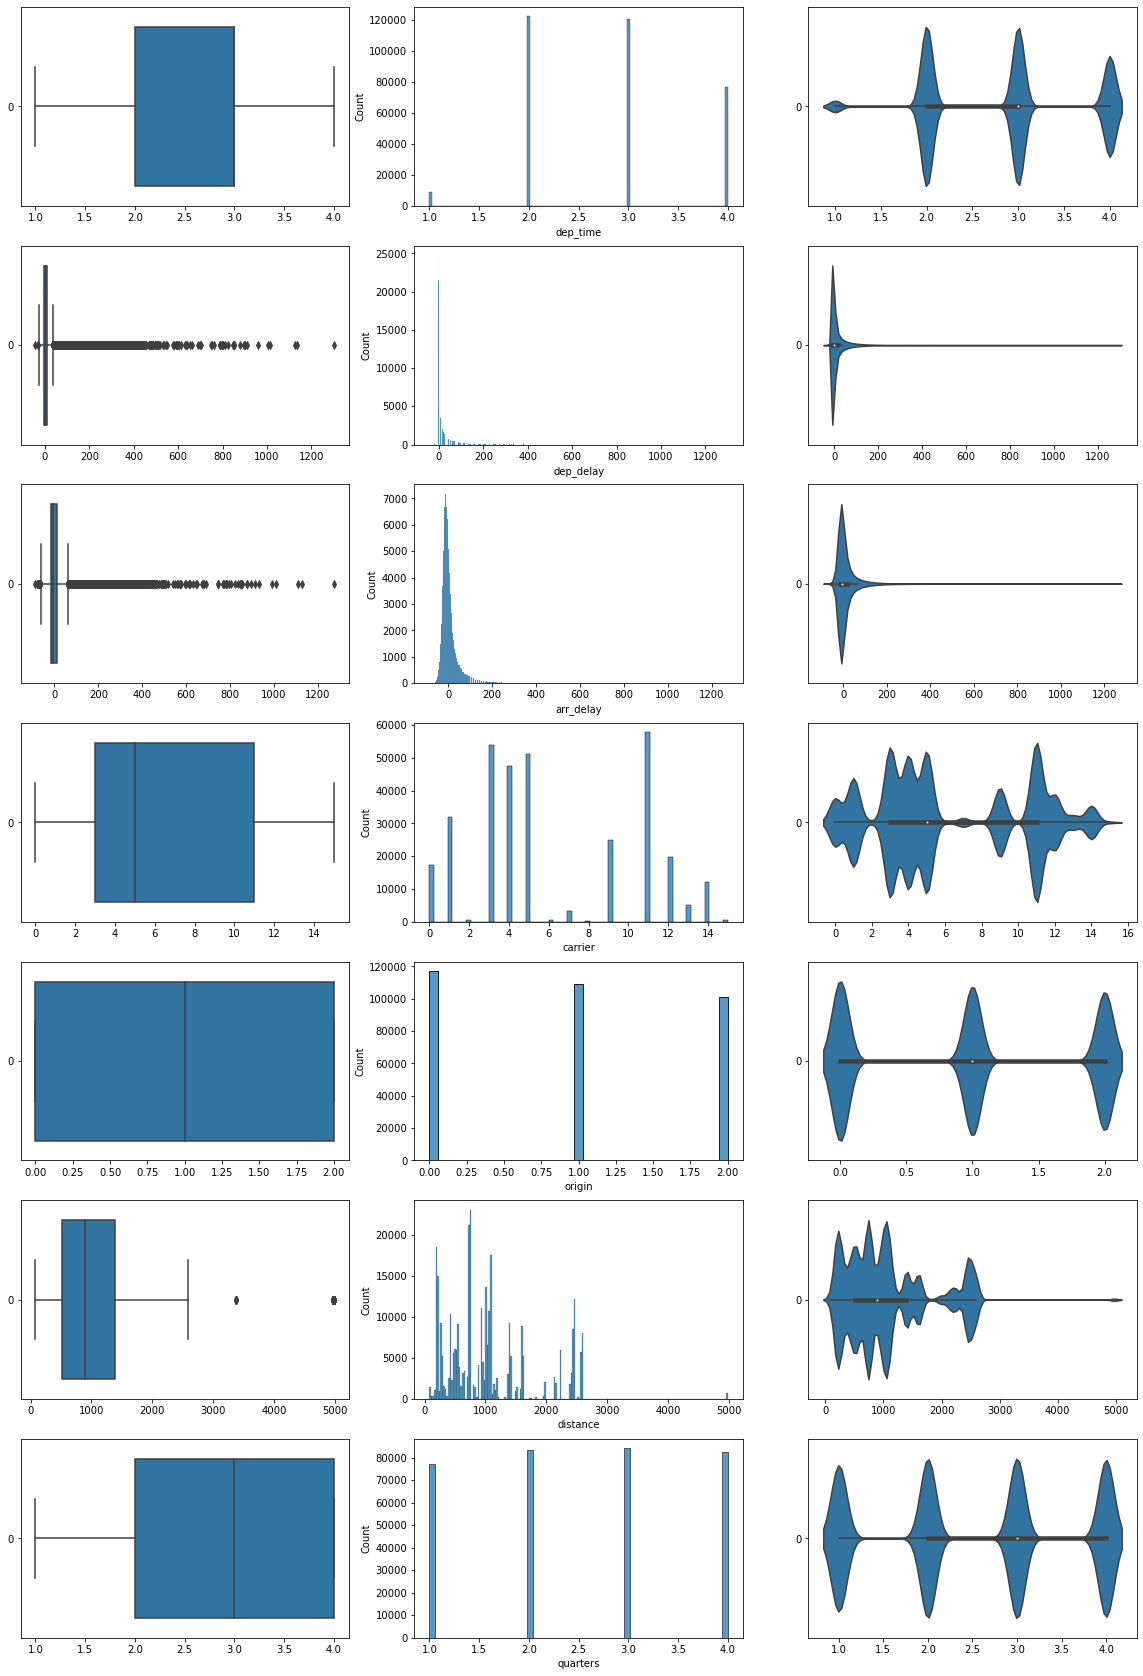

In [12]:
# Draw the distributions of all variables

import matplotlib.pyplot as plt

f, axes = plt.subplots(7, 3, figsize=(20, 30))

count = 0
for var in linearReg:
    sb.boxplot(data = linearReg[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = linearReg[var], ax = axes[count,1])
    sb.violinplot(data = linearReg[var], orient = "h", ax = axes[count,2])
    count += 1

<AxesSubplot:>

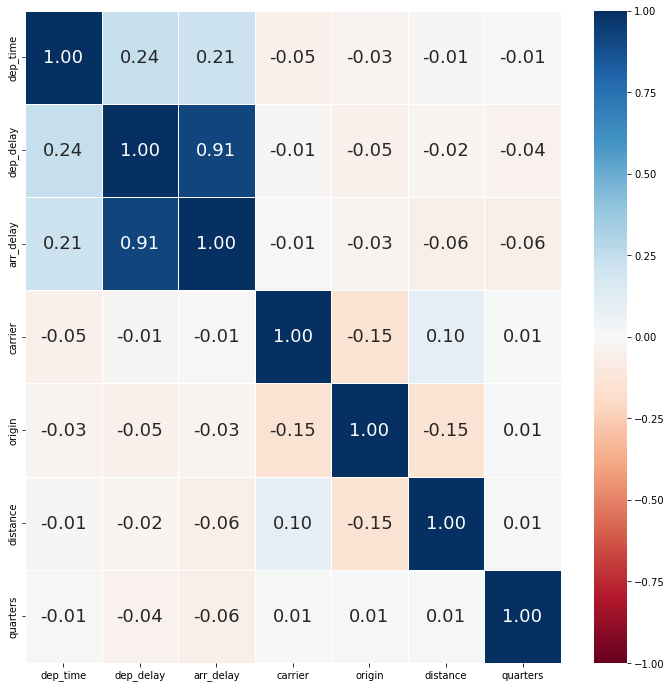

In [13]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(linearReg.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

<AxesSubplot:xlabel='quarters', ylabel='arr_delay'>

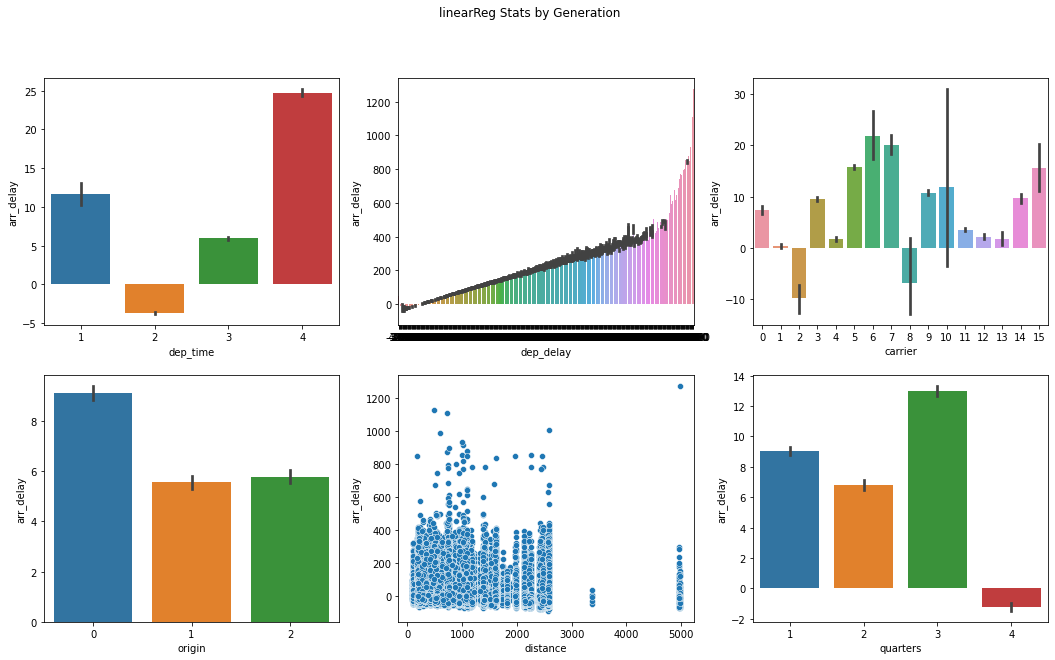

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('linearReg Stats by Generation')

sb.barplot(ax=axes[0, 0], data=linearReg, x='dep_time', y='arr_delay')
sb.barplot(ax=axes[0, 1], data=linearReg, x='dep_delay', y='arr_delay')
sb.barplot(ax=axes[0, 2], data=linearReg, x='carrier', y='arr_delay')
sb.barplot(ax=axes[1, 0], data=linearReg, x='origin', y='arr_delay')
sb.scatterplot(ax=axes[1, 1], data=linearReg, x='distance', y='arr_delay')
sb.barplot(ax=axes[1, 2], data=linearReg, x='quarters', y='arr_delay')

# Linear Regression Model

In [15]:
# Linear regression

X = linearReg.drop(['arr_delay'], axis='columns')
y = linearReg['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

# To retrieve the intercept:
print(regressor.intercept_)

# For retrieving the slope:
print(regressor.coef_)

y_pred = regressor.predict(X_test)

linprediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(linprediction)

print("Model Predictions: ",y_pred)
print("R2 score :--->>",r2_score(y_test,y_pred))
print("MSE",mean_squared_error(y_test,y_pred))
print("MAE",mean_absolute_error(y_test,y_pred))

-1.058116028391912
[-0.31867302  1.018312    0.10975515  0.50859167 -0.00251528 -0.98206519]
        Actual  Predicted
197269   -22.0 -11.019704
127478   -10.0  -6.611745
53766     -4.0  -7.091884
315904   -20.0  -6.406228
203937    -4.0  -8.103894
...        ...        ...
190625   -25.0  -9.900665
183932     4.0  21.241619
232444   -18.0 -11.774981
187901     2.0  -9.004752
57908    -12.0 -12.769031

[65470 rows x 2 columns]
Model Predictions:  [-11.01970436  -6.61174462  -7.09188364 ... -11.77498148  -9.00475177
 -12.76903134]
R2 score :--->> 0.8444925719763076
MSE 328.90510442008167
MAE 13.149355480357897


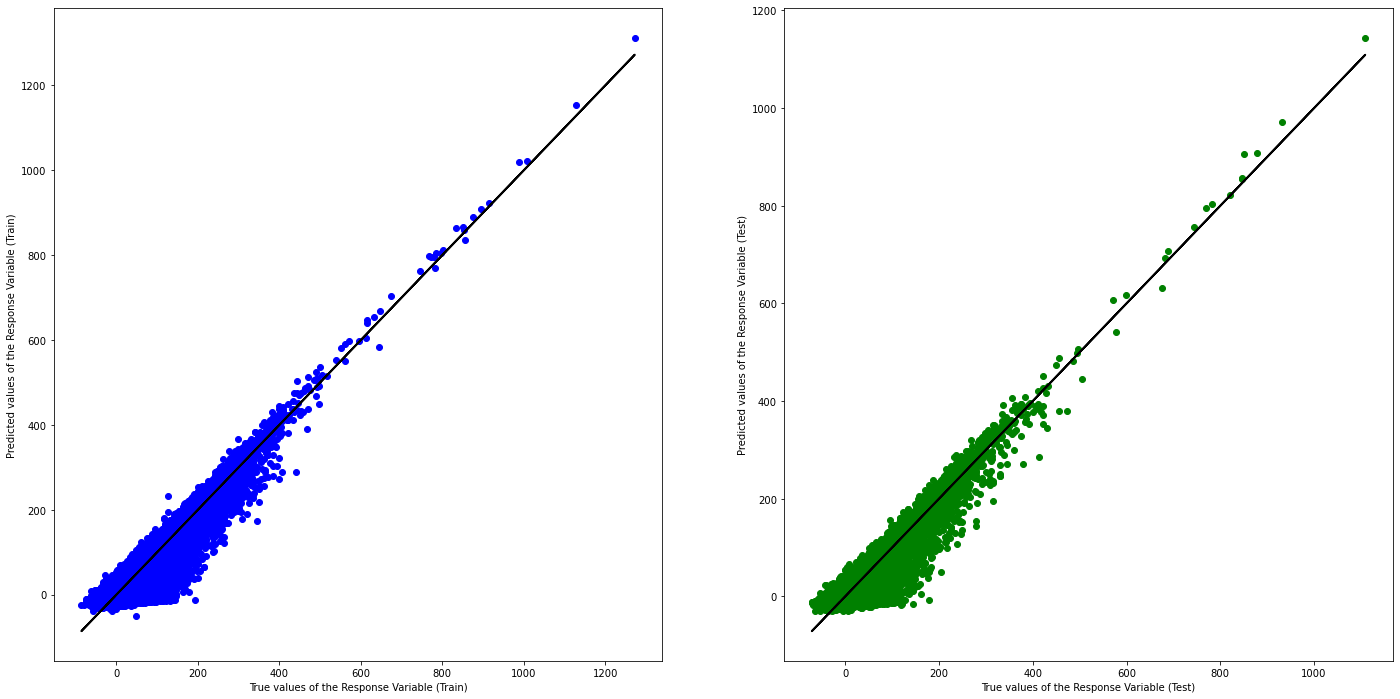

Explained Variance (R^2) on Train Set 	: 0.8380086480392269
Explained Variance (R^2) on Test Set 	: 0.8444925719763076
Mean Squared Error (MSE) on Train Set 	: 317.72054598407016
Mean Squared Error (MSE) on Test Set 	: 328.90510442008167


In [16]:

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)


f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, color="black", linewidth = 2)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, color="black", linewidth = 2)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

print("Explained Variance (R^2) on Train Set \t:", regressor.score(X_train, y_train))
print("Explained Variance (R^2) on Test Set \t:", regressor.score(X_test, y_test))
print("Mean Squared Error (MSE) on Train Set \t:", mean_squared_error(y_train, y_train_pred))
print("Mean Squared Error (MSE) on Test Set \t:", mean_squared_error(y_test, y_test_pred))


In [17]:
# Checking prediction results vs the actual results for accuracy

linprediction["match"]=linprediction.apply(
    lambda row: ((row.Actual<=0) and (row.Predicted<=0))or((row.Actual>0) and (row.Predicted>0)), axis=1)
matchCount=len(linprediction[linprediction['match']])
totalCount=len(linprediction)
print("Accuracy of prediction: ",(matchCount*100/totalCount), "%")

Accuracy of prediction:  79.31113487093326 %


# Logistic Regression Model

In [18]:
# Data clean up for logistics regression

# We will only be using month, dep_time, sched_dep_time, dep_delay,carrier, origin, dest to predict arr_delay
logReg=data.drop(['arr_time','sched_arr_time','air_time', 'distance'], axis='columns')

# Since logistic regression works best for catergorical values, we will predict if there will be an arrival delay or not.

# Convert values <=0 to 0 and values >0 to 1 for arr_delay and dep_delay. 0 means arrive on time or early, 1 means delay.

arrDelConditions = [
    (logReg['arr_delay'] <= 0),
    (logReg['arr_delay'] >0)
]

logReg['arr_delay'] = np.select(arrDelConditions, [0,1])

depDelConditions = [
    (logReg['dep_delay'] <= 0),
    (logReg['dep_delay'] >0)
]

logReg['dep_delay'] = np.select(depDelConditions, [0,1])

# In NYC, seasons are as follow:
# Winter: December to February.
# Spring: March to May.
# Summer: June to August.
# Autumn: September to November.
# Instead of having months, we will change it to quarters.
# 1 for Winter
# 2 for Spring
# 3 for Summer
# 4 for Autumn

monthConditions = [
    (logReg['month'] == 12)|(logReg['month']==1)|(logReg['month']==2),
    (logReg['month'] == 3)|(logReg['month']==4)|(logReg['month']==5),
    (logReg['month'] == 6)|(logReg['month']==7)|(logReg['month']==8),
    (logReg['month'] == 9)|(logReg['month']==10)|(logReg['month']==11)
]

values = [1,2,3,4]

logReg['quarters'] = np.select(monthConditions, values)
logReg.drop(["month"],axis="columns",inplace=True);

# We will categorise non-numeric columns origin, dest and carrier

o=logReg['origin'].astype('category')
logReg['origin']=o.cat.codes

d=logReg['dest'].astype('category')
logReg['dest']=d.cat.codes

c=logReg['carrier'].astype('category')
logReg['carrier']=c.cat.codes

# We will group the depature and arrival time into 4 groups as well.
# 1 for 0000-0559
# 2 for 0600-1159
# 3 for 1200-1759
# 4 for 1800-2359

depConditions = [
    ((logReg['dep_time'] >= 0)&(logReg['dep_time']<=559))|(logReg['dep_time'] == 2400),
    (logReg['dep_time'] >= 600)&(logReg['dep_time']<=1159),
    (logReg['dep_time'] >= 1200)&(logReg['dep_time']<=1759),
    (logReg['dep_time'] >= 1800)&(logReg['dep_time']<=2359)
]

logReg['dep_time'] = np.select(depConditions, values)

schDepConditions = [
    ((logReg['sched_dep_time'] >= 0)&(logReg['sched_dep_time']<=559))|(logReg['sched_dep_time'] == 2400),
    (logReg['sched_dep_time'] >= 600)&(logReg['sched_dep_time']<=1159),
    (logReg['sched_dep_time'] >= 1200)&(logReg['sched_dep_time']<=1759),
    (logReg['sched_dep_time'] >= 1800)&(logReg['sched_dep_time']<=2359)
]

logReg['sched_dep_time'] = np.select(schDepConditions, values)

logReg

,dep_time,sched_dep_time,dep_delay,arr_delay,carrier,origin,dest,quarters
0,1,1,1,1,11,0,43,1
1,1,1,1,1,11,2,43,1
2,1,1,1,1,1,1,57,1
3,1,1,0,0,3,1,12,1
4,1,2,0,0,4,2,4,1
...,...,...,...,...,...,...,...,...
336765,4,4,0,0,3,1,98,4
336766,4,4,0,0,3,1,14,4
336767,4,4,0,0,3,1,81,4
336768,4,4,1,1,3,1,11,4


### EDA for Logistic Regression

<AxesSubplot:xlabel='quarters', ylabel='arr_delay'>

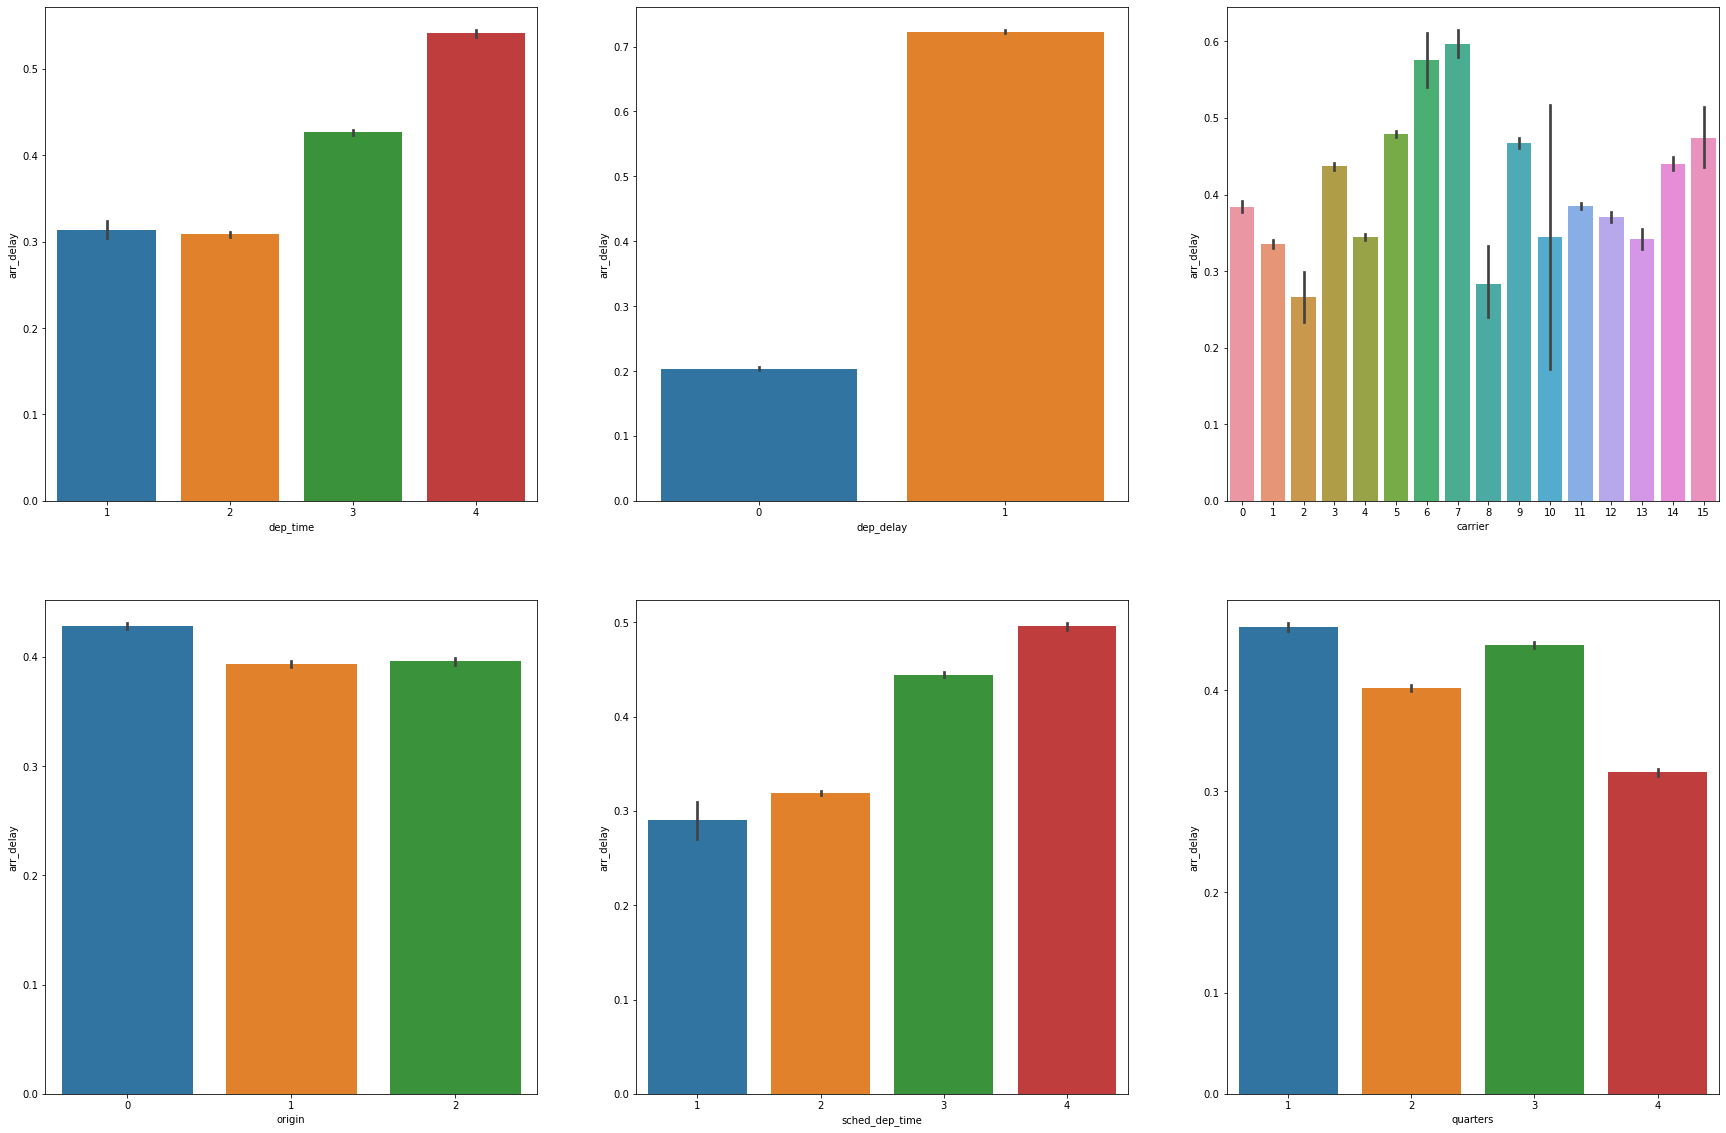

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

sb.barplot(ax=axes[0, 0], data=logReg, x='dep_time', y='arr_delay')
sb.barplot(ax=axes[0, 1], data=logReg, x='dep_delay', y='arr_delay')
sb.barplot(ax=axes[0, 2], data=logReg, x='carrier', y='arr_delay')
sb.barplot(ax=axes[1, 0], data=logReg, x='origin', y='arr_delay')
sb.barplot(ax=axes[1, 1], data=logReg, x='sched_dep_time', y='arr_delay')
sb.barplot(ax=axes[1, 2], data=logReg, x='quarters', y='arr_delay')


### Logistic Regression Model

In [20]:
X=logReg.drop(["arr_delay"],axis="columns")
y=logReg['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LogisticRegression()
regressor.fit(X_train, y_train)

# To retrieve the intercept:
print(regressor.intercept_)

# For retrieving the slope:
print(regressor.coef_)

y_pred = regressor.predict(X_test)

logprediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(logprediction)

[-1.28677235]
[[ 0.33293592 -0.20309334  2.26295526 -0.00494364  0.07267853 -0.00254177
  -0.13220256]]
        Actual  Predicted
197269       0          0
127478       0          0
53766        0          0
315904       0          1
203937       0          0
...        ...        ...
190625       0          0
183932       1          1
232444       0          0
187901       1          0
57908        0          0

[65470 rows x 2 columns]


In [21]:
# Checking prediction results vs the actual results for accuracy

logprediction["match"]=logprediction.apply(
    lambda row: row.Actual==row.Predicted, axis=1)
matchCount=len(logprediction[logprediction['match']])
totalCount=len(logprediction)
print("Accuracy of prediction: ",(matchCount*100/totalCount), "%")

Accuracy of prediction:  76.62746296013441 %


# Multi-variate Decision Tree

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7674471887458186

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7671758057125401

TPR Train :	 0.6933808391227098
TNR Train :	 0.8181128338360032

FPR Train :	 0.18188716616399683
FNR Train :	 0.3066191608772903


[Text(1339.2, 2348.3520000000003, 'dep_delay <= 0.5\ngini = 0.482\nsamples = 261876\nvalue = [155503, 106373]\nclass = Delayed'),
 Text(669.6, 1826.496, 'quarters <= 1.5\ngini = 0.325\nsamples = 159835\nvalue = [127219, 32616]\nclass = Delayed'),
 Text(334.8, 1304.6400000000003, 'dest <= 10.5\ngini = 0.381\nsamples = 35843\nvalue = [26680, 9163]\nclass = Delayed'),
 Text(167.4, 782.7840000000001, 'carrier <= 6.0\ngini = 0.432\nsamples = 3074\nvalue = [2102, 972]\nclass = Delayed'),
 Text(83.7, 260.92800000000034, 'gini = 0.409\nsamples = 2017\nvalue = [1439, 578]\nclass = Delayed'),
 Text(251.10000000000002, 260.92800000000034, 'gini = 0.468\nsamples = 1057\nvalue = [663, 394]\nclass = Delayed'),
 Text(502.20000000000005, 782.7840000000001, 'dest <= 22.5\ngini = 0.375\nsamples = 32769\nvalue = [24578, 8191]\nclass = Delayed'),
 Text(418.5, 260.92800000000034, 'gini = 0.281\nsamples = 3819\nvalue = [3172, 647]\nclass = Delayed'),
 Text(585.9, 260.92800000000034, 'gini = 0.385\nsamples =

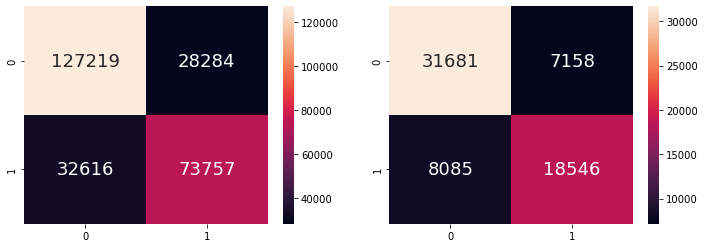

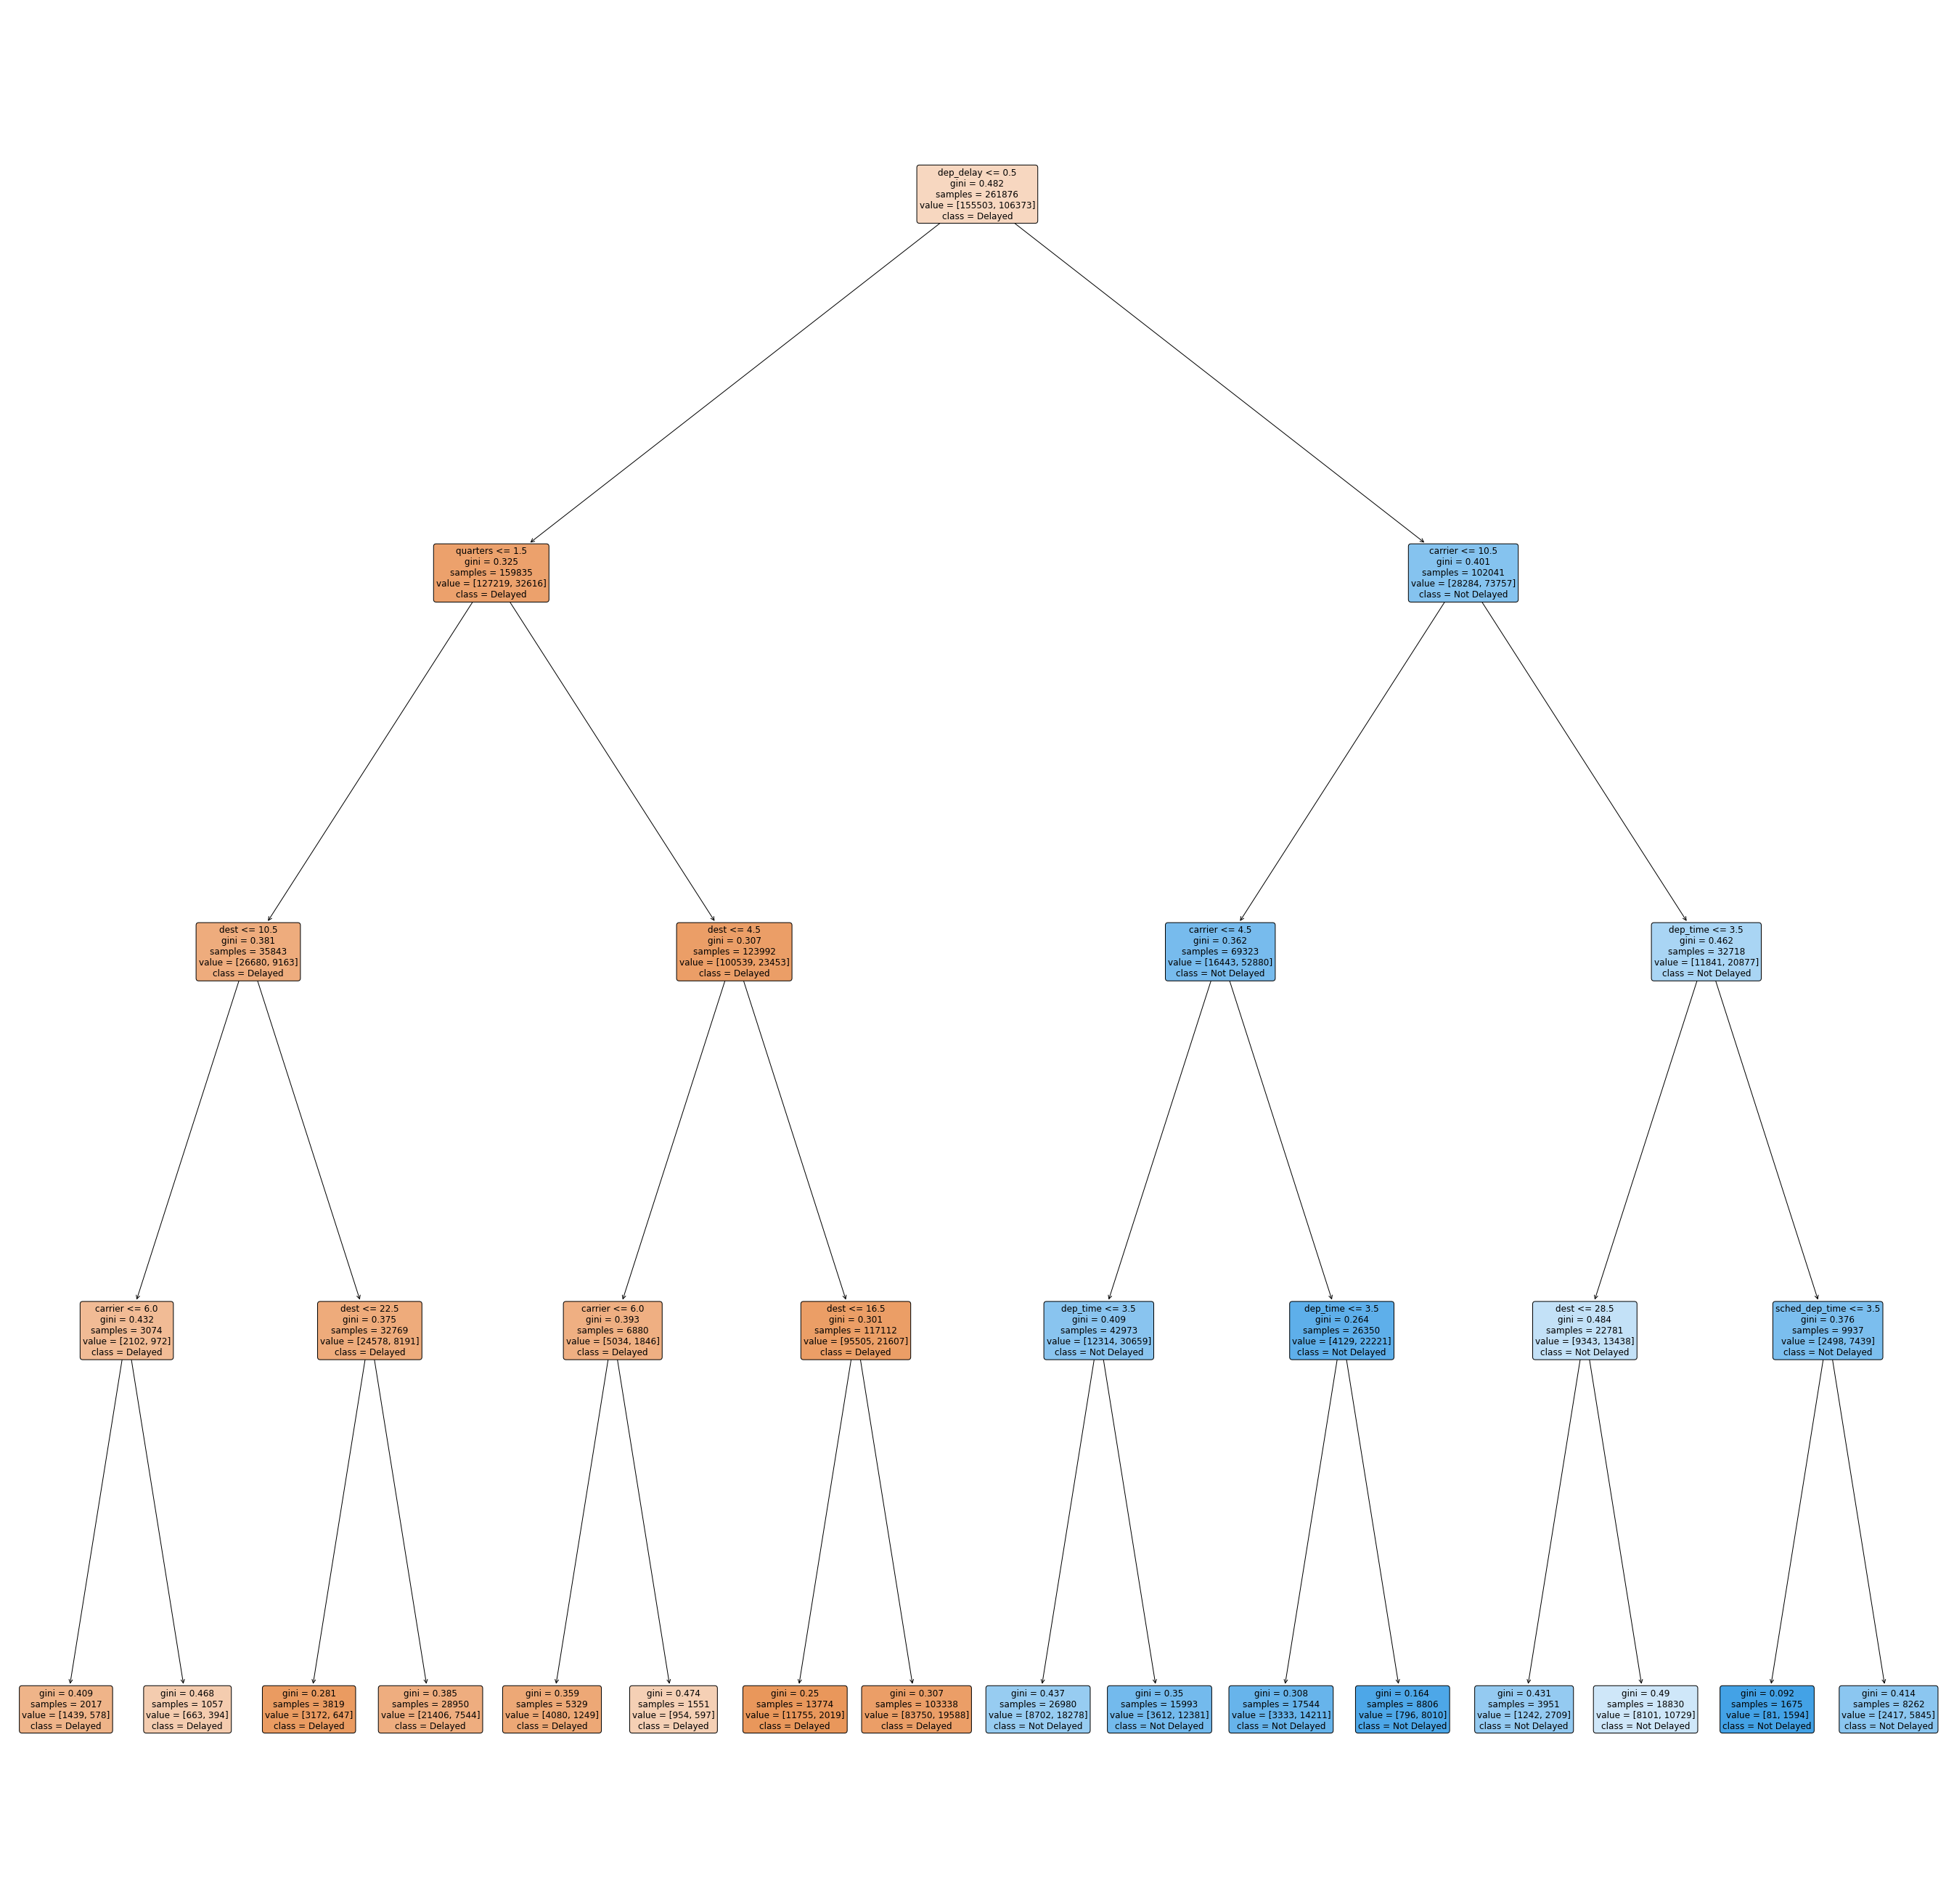

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X=logReg.drop(["arr_delay"],axis="columns")
y=logReg['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a Decision Tree Classifier object
dectree = DecisionTreeClassifier(max_depth = 4)
dectree.fit(X_train, y_train)

y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Y (1) predicted Y (1)
fpTrain = cmTrain[0][1] # False Positives : N (0) predicted Y (1)
tnTrain = cmTrain[0][0] # True Negatives : N (0) predicted N (0)
fnTrain = cmTrain[1][0] # False Negatives : Y (1) predicted N (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(48,48))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=X_train.columns, 
          class_names=["Delayed","Not Delayed"])

# Random Forest Classifier

In [23]:
# We can reuse the data used in logistic regression for RandomForestClassifier

X=logReg.drop(["arr_delay"],axis="columns")
y=logReg['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor =  RandomForestClassifier()
regressor.fit(X_train, y_train)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", regressor.score(X_train, y_train))
print()
# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", regressor.score(X_test, y_test))
print()

y_pred = regressor.predict(X_test)

rfcprediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(rfcprediction)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7762070598298432

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7673438215976783

        Actual  Predicted
197269       0          0
127478       0          0
53766        0          0
315904       0          1
203937       0          0
...        ...        ...
190625       0          0
183932       1          1
232444       0          0
187901       1          0
57908        0          0

[65470 rows x 2 columns]


# Use Linear Regression to check for delays

In [24]:
# Though Linear regression is shown to have a higher accuracy, 
# we have to keep in mind that the data used for prediction is different.

# Linear regression with the logistics regression dataset

X = logReg.drop(["arr_delay"],axis="columns")
y = logReg['arr_delay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

# To retrieve the intercept:
print(regressor.intercept_)

# For retrieving the slope:
print(regressor.coef_)

y_pred = regressor.predict(X_test)

linprediction = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(linprediction)

linprediction["match"]=linprediction.apply(
    lambda row: ((row.Actual<=0) and (row.Predicted<=0))or((row.Actual>0) and (row.Predicted>0)), axis=1)
matchCount=len(linprediction[linprediction['match']])
totalCount=len(linprediction)
print("Accuracy of prediction: ",(matchCount*100/totalCount), "%")

0.22080582472797058
[ 6.18669186e-02 -3.92919252e-02  5.04082908e-01 -8.94461310e-04
  1.28761390e-02 -4.54702854e-04 -2.31680096e-02]
        Actual  Predicted
197269       0   0.225880
127478       0   0.255783
53766        0   0.213531
315904       0   0.674233
203937       0   0.246755
...        ...        ...
190625       0   0.185681
183932       1   0.772680
232444       0   0.175725
187901       1   0.181499
57908        0   0.189797

[65470 rows x 2 columns]
Accuracy of prediction:  40.67664579196578 %


In [25]:
# Results returns a highly inaccurate prediction.
# Since we are deciding whether the flight was delayed or not, the log regression is more suitable